In [13]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# train test split from sklearn
from sklearn.model_selection import train_test_split

# Import Torch 
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# graphing
from matplotlib import pyplot as plt

# Image processing
from PIL import Image, ImageOps, ImageEnhance

In [14]:
def load_image(filepath) :
    im1 = Image.open(filepath)
    im1.load()

#    im1 = img.crop((0, 0, 300, 300)) 
    newsize = (32,32)
    im1 = im1.resize(newsize) 
    data = np.asarray(im1, dtype="int32")
    return data

In [15]:
# load data
NUM_EXAMPLES = 1000
NUM_TEST_EXAMPLES = 100

training_set_cats = []
training_set_dogs = []

for i, filename in enumerate(os.listdir('dataset/training_set/cats')):
    if i == NUM_EXAMPLES:
        break
    filepath = os.path.join('dataset/training_set/cats', filename)
    training_set_cats.append(load_image(filepath))
for i, filename in enumerate(os.listdir('dataset/training_set/dogs')):
    if i == NUM_EXAMPLES:
        break
    filepath = os.path.join('dataset/training_set/dogs', filename)
    training_set_dogs.append(load_image(filepath))
    

test_set_cats = []
test_set_dogs = []

for i, filename in enumerate(os.listdir('dataset/test_set/cats')):
    if i == NUM_TEST_EXAMPLES:
        break
    filepath = os.path.join('dataset/test_set/cats', filename)
    test_set_cats.append(load_image(filepath))
for i, filename in enumerate(os.listdir('dataset/test_set/dogs')):
    if i == NUM_TEST_EXAMPLES:
        break
    filepath = os.path.join('dataset/test_set/dogs', filename)
    test_set_dogs.append(load_image(filepath))


In [16]:
# convert to numpy arrays (NUM_EXAMPLES, 32, 32, 3)
X_train_cats = np.stack(training_set_cats)
X_train_dogs = np.stack(training_set_dogs)
X_test_cats = np.stack(test_set_cats)
X_test_dogs = np.stack(test_set_dogs)

# set labels
y_train_cats = np.ones(NUM_EXAMPLES)
y_train_dogs = np.zeros(NUM_EXAMPLES)
y_test_cats = np.ones(NUM_TEST_EXAMPLES)
y_test_dogs = np.zeros(NUM_TEST_EXAMPLES)

# combine cat and dog data
X_train = np.concatenate((X_train_cats, X_train_dogs))
y_train = np.concatenate((y_train_cats, y_train_dogs)).astype(np.long)
X_test = np.stack((X_test_cats, X_test_dogs))
y_test = np.stack((y_test_cats, y_test_dogs)).astype(np.long)

In [17]:
class CatsDogsDataSet(Dataset):
     def __init__(self, X, y,
                 transform = transforms.Compose([
                     transforms.ToPILImage(), 
                     transforms.Grayscale(num_output_channels=1),
                     transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):       
        # training data
        self.X = X #.reshape((-1,32,32)).astype(np.uint8)[:,:,:,None]
        self.y = y
        self.transform = transform
    
     def __len__(self):
        return len(self.X)

     def __getitem__(self, idx):
        return self.transform(np.uint8(self.X[idx])), self.y[idx]


In [18]:
batch_size = 10

# create datasets from np arrays
train_dataset = CatsDogsDataSet(X_train, y_train)
test_dataset = CatsDogsDataSet(X_test, y_test)

# torch dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.features = nn.Sequential(
            # Convolution 1
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            
            # Convolution 1
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            
            # Convolution 3
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),

            # Convolution 4
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            
            # Convolution 5
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            
            # Convolution 6
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(512,2)
        )
                                     
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1) # flatten
        out = self.classifier(out)
        return out

print(CNNModel())

CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(

In [20]:
# set up optimizer, loss function, lr scheduler
model = CNNModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
expr_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [21]:
loss_list = []
accuracy_list = []
iteration_list = []

def train(epoch):
    model.train()
    expr_lr_scheduler.step()
    
    for i, (features, labels) in enumerate(train_loader):
        features, labels = Variable(features), Variable(labels)
        if torch.cuda.is_available():
            features = features.cuda()
            labels = labels.cuda()

        # zero out gradients from previous iteration
        optimizer.zero_grad()

        # forward propagation
        output = model(features)
        
        # calculate loss
        loss = criterion(output, labels)

        # backprop
        loss.backward()
        
        # update params (gradient descent)
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (i + 1) * len(features), len(train_loader.dataset),
                100. * (i + 1) / len(train_loader), loss.data.item()))

In [22]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for features, labels in data_loader:
        with torch.no_grad():
            features, labels = Variable(features), Variable(labels)
            if torch.cuda.is_available():
                features = features.cuda()
                labels = features.cuda()
            output = model(features)
            
        loss += F.cross_entropy(output, labels, size_average=False).data.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    print('Epoch: {}, Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
        epoch,
        loss, correct, len(data_loader.dataset),
        accuracy))
    loss_list.append(loss)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)

In [23]:
n_epochs = 25

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

Train Epoch: 0 [1000/2000 (50%)]	Loss: 0.625350
Train Epoch: 0 [2000/2000 (100%)]	Loss: 0.651890
Epoch: 0, Average loss: 0.7247, Accuracy: 1074/2000 (53.700%)
Train Epoch: 1 [1000/2000 (50%)]	Loss: 0.642302
Train Epoch: 1 [2000/2000 (100%)]	Loss: 0.643504
Epoch: 1, Average loss: 0.6686, Accuracy: 1212/2000 (60.600%)
Train Epoch: 2 [1000/2000 (50%)]	Loss: 0.859553
Train Epoch: 2 [2000/2000 (100%)]	Loss: 0.429001
Epoch: 2, Average loss: 0.6854, Accuracy: 1234/2000 (61.700%)
Train Epoch: 3 [1000/2000 (50%)]	Loss: 0.822274
Train Epoch: 3 [2000/2000 (100%)]	Loss: 0.658389
Epoch: 3, Average loss: 0.6679, Accuracy: 1257/2000 (62.850%)
Train Epoch: 4 [1000/2000 (50%)]	Loss: 0.571038
Train Epoch: 4 [2000/2000 (100%)]	Loss: 0.932915
Epoch: 4, Average loss: 0.6178, Accuracy: 1276/2000 (63.800%)
Train Epoch: 5 [1000/2000 (50%)]	Loss: 0.640254
Train Epoch: 5 [2000/2000 (100%)]	Loss: 0.744373
Epoch: 5, Average loss: 0.5711, Accuracy: 1422/2000 (71.100%)
Train Epoch: 6 [1000/2000 (50%)]	Loss: 0.60733

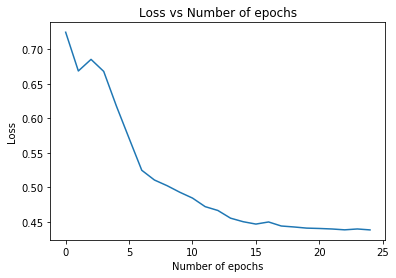

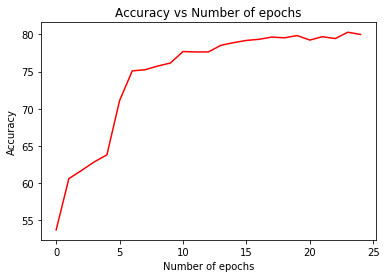

In [24]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of epochs")
plt.show()

In [25]:
# save model
torch.save(model, 'cnn-model.pt')